In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
from skimage import measure, segmentation, feature
from vis_utils import load_volume, VolumeVisualizer, ColorMapVisualizer
from scipy.ndimage import zoom
from skimage.morphology import skeletonize, skeletonize_3d, binary_dilation

from skimage import filters, morphology

from scipy.ndimage.filters import convolve, correlate
from scipy import signal

from skimage.filters import frangi, sato
from skimage.draw import line_nd

from PIL import Image
import pickle

from queue import PriorityQueue

In [2]:
source_dir = './data/P12/'
skeleton = np.load(source_dir + 'skeleton.npy')
thiccness_map = np.load(source_dir + 'thiccness-map.npy')

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
skeleton = np.pad(skeleton, 1)
thiccness_map = np.pad(thiccness_map, 1)

In [3]:
def visualize_addition(base, base_with_addition):
    base = (base.copy() > 0).astype(np.uint8)
    addition = (base_with_addition > 0).astype(np.uint8)
    addition[base == 1] = 0
    ColorMapVisualizer(base + addition * 4).visualize()
    
def visualize_lsd(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize()
    
def visualize_gradient(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize(gradient=True)
    
def visualize_mask_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8), binary=True).visualize()
    
def visualize_mask_non_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8) * 255, binary=False).visualize()
    
def visualize_skeleton(mask, visualize_mask=True, visualize_both_versions=False):
    skeleton = skeletonize((mask > 0).astype(np.uint8))
    if not visualize_mask or visualize_both_versions:
        VolumeVisualizer(skeleton, binary=True).visualize()
    if visualize_mask or visualize_both_versions:
        skeleton = skeleton.astype(np.uint8) * 4
        mask = (mask > 0).astype(np.uint8) * 3
        mask[skeleton != 0] = 0
        ColorMapVisualizer(skeleton + mask).visualize()

def visualize_ultimate(lsd, base_mask):
    visualize_lsd(lsd)
    visualize_mask_non_bin(lsd)
    visualize_addition(base_mask, lsd)
    visualize_skeleton(lsd, visualize_mask=True)

In [4]:
def trim_skeleton(skeleton):   
    # TODO: fix wczesniejszych skeletonow !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!TODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTO
    padded_skeleton = np.pad(skeleton, 1)
    new_skeleton = np.zeros(padded_skeleton.shape)
    queue = [tuple(np.argwhere(padded_skeleton)[0])]
    
    while(len(queue) > 0):
        x, y, z = queue.pop(0)
        
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                for dz in [-1, 0, 1]:
                    if dx == dy == dz == 0:
                        continue
                    
                    neighbour_x = x + dx
                    neighbour_y = y + dy
                    neighbour_z = z + dz
                    if padded_skeleton[neighbour_x, neighbour_y, neighbour_z] == 0:
                        continue
                        
                    if new_skeleton[neighbour_x, neighbour_y, neighbour_z] == 0:
                        queue.append((neighbour_x, neighbour_y, neighbour_z))
                        new_skeleton[neighbour_x, neighbour_y, neighbour_z] += 1;
                        new_skeleton[x, y, z] += 1
                        
    return (new_skeleton[1:-1, 1:-1, 1:-1] > 1).astype(np.uint8)



def mark_bifurcation_regions(skeleton):
    
    padded_skeleton = np.pad(skeleton, 1)
    bifurcations_map = np.zeros(padded_skeleton.shape)
    
    for skeleton_voxel in np.argwhere(padded_skeleton > 0):
        x, y, z = tuple(skeleton_voxel)
        kernel_radius = 1
        kernel = np.ones((3, 3, 3))
        kernel[1, 1, 1] = 0
        
        skeleton_slice = padded_skeleton[
            x-kernel_radius:x+kernel_radius + 1,
            y-kernel_radius:y+kernel_radius + 1,
            z-kernel_radius:z+kernel_radius + 1
        ]
        
        intersections = (skeleton_slice > 0) * kernel
        bifurcations_map[x, y, z] = np.sum(intersections)
        
    return (bifurcations_map[1:-1, 1:-1, 1:-1] > 2).astype(np.uint8)

def mark_leaves(skeleton):
    trimmed = trim_skeleton(skeleton)
    leaves = skeleton - trimmed
    return leaves

def mark_nodes(skeleton):
    bifurcation_map = mark_bifurcation_regions(skeleton)
    leaves_map = mark_leaves(skeleton)
    return bifurcation_map + leaves_map

In [6]:
class Node:
    def __init__(self, coords):
        self.coords = coords
        self.edges = []
        self.data = {}
            
    def add_edge(self, edge):
        self.edges.append(edge)
        
    def get_neighbours(self):
        return [e.node_a if e.node_a.coords != self.coords else e.node_b for e in self.edges]
    
    def copy_without_edges(self):
        copied_node = Node(self.coords)
        copied_node.data = self.data
        return copied_node
    
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __hash__(self):
        return hash(self.coords)
    
    def __repr__(self):
        return f'Node {str(self.coords)}'
        
class Edge:
    def __init__(self, node_a, node_b):
        self.node_a = node_a
        self.node_b = node_b
        self.data = {}
        
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __repr__(self):
        return f'Edge {self.node_a.coords} -> {self.node_b.coords}'

In [14]:
def construct_graph(skeleton, nodes_mask, thiccness_map):
    nodes_labels = measure.label(nodes_mask)
    nodes_props = measure.regionprops(nodes_labels)
    print('nodes found (regions on nodes mask):', nodes_labels.max())
    voxel_to_node = dict()
    
    for props in nodes_props:
        if props.label < 1:
            continue
            
        node = Node(tuple(props.coords[0]))
        node['voxels'] = props.coords
        node['thiccness'] = thiccness_map[tuple(props.coords[0])]
        
        for c in props.coords:
            voxel_to_node[tuple(c)] = node
            
    edges_mask = skeleton - nodes_mask
    edges_labels = measure.label(edges_mask > 0)
    print('edges found:', edges_labels.max())
    
    visited = np.zeros(skeleton.shape, dtype=np.bool)
    
    def find_touching_nodes(source_voxel):
        touching_nodes = set()
        queue = [source_voxel]
        while len(queue) > 0:
            x, y, z = queue.pop(0)
            
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    for dz in [-1, 0, 1]:
                        if dx == dy == dz == 0:
                            continue

                        neighbour_x = x + dx
                        neighbour_y = y + dy
                        neighbour_z = z + dz
                        if visited[neighbour_x, neighbour_y, neighbour_z]:
                            continue
                            
                        potential_node = voxel_to_node.get((neighbour_x, neighbour_y, neighbour_z))
                        if potential_node is not None:
                            touching_nodes.add(potential_node)

                        if edges_mask[neighbour_x, neighbour_y, neighbour_z] == 1:
                            queue.append((neighbour_x, neighbour_y, neighbour_z))
                            visited[neighbour_x, neighbour_y, neighbour_z] = True
        return list(touching_nodes)
       
        
    edges_props = measure.regionprops(edges_labels)
    
    edges = []
    bad_edges = []
    for props in edges_props:
        edge_voxel = props.coords[0]
        touching_nodes = find_touching_nodes(edge_voxel)
        if len(touching_nodes) != 2:
            print(f'bad edge found! touching nodes count: {len(touching_nodes)}')
            bad_edges.append(props.coords)
            continue
            
        edge = Edge(touching_nodes[0], touching_nodes[1])
        edge['voxels'] = props.coords
        edges.append(edge)
    return edges, bad_edges

In [15]:
bifurcations_mask = mark_bifurcation_regions(skeleton)
leaves_mask = mark_leaves(skeleton)
nodes_mask = ((bifurcations_mask + leaves_mask) > 0).astype(np.uint8)

In [16]:
%%time
edges, bad_edges = construct_graph(skeleton, nodes_mask, thiccness_map)
print("Number of bad edged found:", len(bad_edges))

nodes found (regions on nodes mask): 2300
edges found: 2338
bad edge found! touching nodes count: 1
bad edge found! touching nodes count: 1
bad edge found! touching nodes count: 1
bad edge found! touching nodes count: 1
bad edge found! touching nodes count: 1
bad edge found! touching nodes count: 1
bad edge found! touching nodes count: 1
Number of bad edged found: 7
CPU times: user 6.56 s, sys: 2.54 s, total: 9.1 s
Wall time: 10.9 s


## DAG cleaning

In [35]:
def convert_to_nodes_list(edges):
    nodes = {}
    for e in edges:
        nodes[e.node_a] = e.node_a.copy_without_edges()
        nodes[e.node_b] = e.node_b.copy_without_edges()
        
    for e in edges:
        new_edge = Edge(nodes[e.node_a], nodes[e.node_b])
        new_edge.data = e.data
        nodes[e.node_a].add_edge(new_edge)
        nodes[e.node_b].add_edge(new_edge)
        
    return list(nodes.values())


def merge_edges(a, b):
        new_edge = Edge(a.node_a, b.node_b)
        new_edge.data = a.data
        new_edge['voxels'] = np.concatenate([a['voxels'], b.node_a['voxels'], b['voxels']])
        return new_edge


def find_tree_root_candidates(nodes, root_degree):
    proper_degree_nodes = [node for node in nodes if len(node.edges) == root_degree]
    root_thickness = max(map(lambda node: node['thiccness'], proper_degree_nodes))
    root_candidates = [node for node in proper_degree_nodes if node['thiccness'] == root_thickness]
    return root_candidates


def remove_dag_cycles(root):
    counter = 0
    
    new_root = root.copy_without_edges()
    coords_to_old_parents = {}
    coords_to_new_node = { new_root.coords: new_root }
    
    queue = PriorityQueue()
    for node in root.get_neighbours():
        coords_to_old_parents[node.coords] = [root]
        queue.put(((-node['thiccness'], counter), node))
        counter += 1
        
    while not queue.empty():
        _, node = queue.get()
        
        if coords_to_new_node.get(node.coords) is not None:
            continue
        
        parent_candidates = coords_to_old_parents[node.coords]
        proper_parent_thiccness = min([p['thiccness'] for p in parent_candidates])
        proper_parent = [p for p in parent_candidates if p['thiccness'] == proper_parent_thiccness][0]
        edge_from_parent = [e for e in proper_parent.edges if e.node_a == node or e.node_b == node][0]
        
        new_node = node.copy_without_edges()
        new_parent = coords_to_new_node[proper_parent.coords]
        new_edge = Edge(new_parent, new_node)
        new_edge.data = edge_from_parent.data
        new_parent.add_edge(new_edge)
        
        coords_to_new_node[new_node.coords] = new_node
        
        for neighbour in node.get_neighbours():
            parents = coords_to_old_parents.get(neighbour.coords, [])
            coords_to_old_parents[neighbour.coords] = parents + [node]
            queue.put(((-neighbour['thiccness'], counter), neighbour))
            counter += 1
            
    return new_root


def remove_dag_redundant_nodes(root):
    
    new_root = root.copy_without_edges()
    for edge in root.edges:
        new_neighbour = remove_dag_redundant_nodes(edge.node_b)
        
        if len(new_neighbour.edges) == 1:
            merged_edge = merge_edges(edge, new_neighbour.edges[0])
            new_root.add_edge(merged_edge)
            
        else:
            new_edge = Edge(new_root, new_neighbour)
            new_edge.data = edge.data
            new_root.add_edge(new_edge)
            
    return new_root


def get_nodes_with_dfs(root):
    
    nodes = [root]
    for e in root.edges:
        nodes += get_nodes_with_dfs(e.node_b)
        
    return nodes


def get_edges_with_dfs(root):
    
    edges = []
    for e in root.edges:
        edges += [e]
        edges += get_edges_with_dfs(e.node_b)
        
    return edges

In [36]:
%%time

nodes = convert_to_nodes_list(edges)
root_candidates = find_tree_root_candidates(nodes, 1)
print(f'found {len(root_candidates)} root candidate(s)')

root = root_candidates[0]
clean_root = remove_dag_cycles(root)
clean_root = remove_dag_redundant_nodes(clean_root)
clean_nodes = get_nodes_with_dfs(clean_root)
clean_edges = get_edges_with_dfs(clean_root)

print(f'nodes: {len(clean_nodes)}, edges: {len(clean_edges)}')

found 1 root candidate(s)
nodes: 2223, edges: 2222
CPU times: user 178 ms, sys: 2.07 ms, total: 180 ms
Wall time: 203 ms


## populating with metadata

In [48]:
def fix_nodes_thiccness(root, thiccness_map):
    nodes = get_nodes_with_dfs(root)
    for node in nodes:
        thiccness_list = [thiccness_map[tuple(coords)] for coords in node['voxels']]
        node['thiccness'] = np.mean(thiccness_list)
    

def add_edges_thiccness(root, thiccness_map):
    edges = get_edges_with_dfs(root)
    for edge in edges:
        thiccness_list = [thiccness_map[tuple(coords)] for coords in edge['voxels']]
        edge['thiccness_list'] = np.array(thiccness_list)
        edge['mean_thiccness'] = np.mean(thiccness_list)

In [49]:
%%time
fix_nodes_thiccness(clean_root, thiccness_map)
add_edges_thiccness(clean_root, thiccness_map)

CPU times: user 262 ms, sys: 5.25 ms, total: 267 ms
Wall time: 306 ms


In [51]:
clean_root.edges[0]['thiccness_list']

array([11., 11., 11., 11., 11., 11., 11., 12., 12., 12., 12., 12., 12.])

## DAG visualization

In [53]:
def spherical_kernel(outer_radius, thickness=1, filled=True):    
    outer_sphere = morphology.ball(radius=outer_radius)
    if filled:
        return outer_sphere
    
    thickness = min(thickness, outer_radius)
    
    inner_radius = outer_radius - thickness
    inner_sphere = morphology.ball(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    outer_sphere[begin:end, begin:end, begin:end] -= inner_sphere
    return outer_sphere


def print_kernels(image, nodes, value):
    image = image.copy()
    max_kernel_radius = int(max([node['thiccness'] for node in nodes]))
    kernels = [spherical_kernel(radius) for radius in range(max_kernel_radius + 1)]
    
    padded_image = np.pad(image, max_kernel_radius)
    kernels_image = np.zeros(padded_image.shape)
    
    for node in nodes:
        x, y, z = (coord + max_kernel_radius for coord in node.coords)
        kernel_radius = int(node['thiccness'])
        kernel = kernels[kernel_radius]
        
        mask_slice = kernels_image[
            x-kernel_radius:x+kernel_radius + 1,
            y-kernel_radius:y+kernel_radius + 1,
            z-kernel_radius:z+kernel_radius + 1
        ]
        
        mask_slice[:] = np.logical_or(mask_slice, kernel)
            
    kernels_image = kernels_image[
        max_kernel_radius:-max_kernel_radius,
        max_kernel_radius:-max_kernel_radius,
        max_kernel_radius:-max_kernel_radius
    ]
    
    image[kernels_image == 1] = value
    return image


def draw_nodes(image, nodes, value=2):
    nodes_image = print_kernels(image, nodes, value)
    return nodes_image

    
def draw_edges(image, edges, value='thiccness', interpolate=True):
    image = image.copy()

    for i, edge in enumerate(edges):
        fill_value = edge['mean_thiccness'] if value == 'thiccness' else value
        
        if interpolate:
            image[line_nd(edge.node_a.coords, edge.node_b.coords)] = fill_value
        else:
            for v in edge['voxels']:
                image[tuple(v)] = fill_value
        
    return image

In [56]:
visualization = np.zeros(skeleton.shape)
visualization = draw_nodes(visualization, clean_nodes, 15)
visualization = draw_edges(visualization, clean_edges, value='thiccness')
visualize_gradient(visualization)

## saving DAG to file

In [61]:
class DAG:
    def __init__(self, root):
        self.root = root
        self.nodes = get_nodes_with_dfs(root)
        self.edges = get_edges_with_dfs(root)
        

def save_dag(dag, filename):
    with open(filename, 'wb') as output:
        pickle.dump(dag, output)
        

def load_dag(filename):
    with open(filename, 'rb') as input_:
        dag = pickle.load(input_)
        return dag

In [64]:
clean_dag = DAG(clean_root)
save_dag(clean_dag, f'{source_dir}/dag.pkl')

## sample stats

In [37]:
def get_thiccness_by_generation(root):
    def populate_thiccness_dict(node, thiccness_dict, generation):
        thiccness_list = thiccness_dict.get(generation, [])
        thiccness_dict[generation] = thiccness_list + [node['thiccness']]
        
        for e in node.edges:
            populate_thiccness_dict(e.node_b, thiccness_dict, generation + 1)
            
    thiccness_dict = {}
    populate_thiccness_dict(root, thiccness_dict, 1)
    
    return thiccness_dict

In [38]:
thiccness_dict = get_thiccness_by_generation(clean_root)

Text(0, 0.5, 'count')

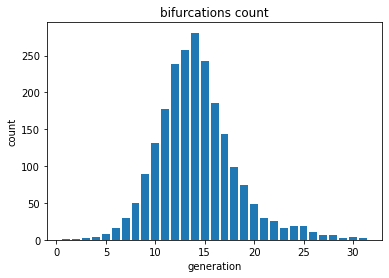

In [39]:
nodes_count = [len(v) for v in thiccness_dict.values()]
generation_indices = list(thiccness_dict.keys())

plt.bar(generation_indices, height=nodes_count)
plt.title('bifurcations count')

plt.xlabel('generation')
plt.ylabel('count')

Text(0, 0.5, 'thickness')

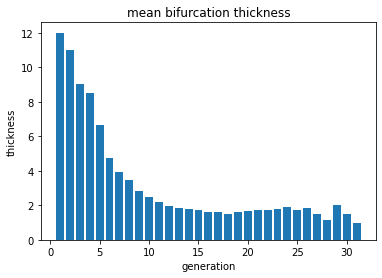

In [40]:
mean_thiccness = [np.mean(v) for v in thiccness_dict.values()]
generation_indices = list(thiccness_dict.keys())

plt.bar(generation_indices, height=mean_thiccness)
plt.title('mean bifurcation thickness')

plt.xlabel('generation')
plt.ylabel('thickness')

In [43]:
np.unique([len(n.edges) for n in clean_nodes], return_counts=True)

(array([0, 1, 2, 3, 4]), array([1181,    1,  918,  107,   16]))

## trash

In [119]:
def get_main_regions(binary_mask, min_size=10_000, connectivity=3):
    labeled = measure.label(binary_mask, connectivity=connectivity)
    region_props = measure.regionprops(labeled)
    
    main_regions_masks = []
    regions_labels = []
    bounding_boxes = []
    
    for props in region_props:
        if props.area >= min_size:
            main_regions_masks.append(props.filled_image)
            regions_labels.append(props.label)
            bounding_boxes.append(props.bbox)
            
    return main_regions_masks, regions_labels, bounding_boxes

volume = np.pad(load_volume('./data/P12/P12_60um_1333x443x864.raw', scale=0.5), 1)
volume = volume > 70
main_regions = get_main_regions(volume)
mask_main = np.pad(main_regions[0][0].astype(np.uint8), 1)

In [121]:
visualize_addition(visualization > 0, mask_main)